# Setting up Variables and Functions

In [1]:
# Importing Pandas to create DataFrame
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

A_VALUE = 50 # remains the same
B_VALUE = 100 
C_VALUE = 300

A_VALUE_S = 50 # remains the same
B_VALUE_S = 0 
C_VALUE_S = 3000


BETA1 = 0.99 # decay factor for buyer
BETA2 = 15 # time difference 
BETA_S = 0.001 # 

### Calculating X and Reputation Score for Buyers/Sellers

In [2]:
'''
Account Age Increment: in Months 
Time_btwn_transactions: in hours
price: in ETH (range: 0.001 to 1)
'''

def calculateX_Buyer(old_x, time_btwn_transactions, price, BETA1, BETA2):
    beta1 = BETA1
    beta2 = BETA2
    temp1 = (time_btwn_transactions-12)/math.sqrt(beta2+(time_btwn_transactions-12)**2) #tolerance is 12 hours 
    
    if price>=2**112:
        price = 2**111
    temp2 = np.log(1+price/10**18) #price is in wei --> 18 decimals 
    
    if time_btwn_transactions >= 16*24:
        timePassed = 16 #in days 
    else:
        timePassed = math.floor(time_btwn_transactions/24)
    return old_x*(beta1**(timePassed)) + temp1*old_x + temp2*old_x


def calculateX_Seller(oldX, rep_score, rincoming, raverage, BETA_S):
    if (rincoming-raverage)==0:
        return oldX
    return oldX + ((BETA_S/abs(rincoming-raverage)))*rep_score/1000*oldX


# calculating reputation score 

def sigmoidal(x, A_VALUE, B_VALUE, C_VALUE):
#     return x
    a = A_VALUE
    b = B_VALUE
    c = C_VALUE
    temp1 = x-b
    temp2 = c + (x-b)*(x-b)
    temp3 = temp1/math.sqrt(temp2)
    temp4 = temp3 +1
    return a * temp4
    

## Graph


**Considerations**
1. If so, what is the tolerance?
2. How long before the reputation can be increased?

**Notes**
1. Parameters are randomly chosen. They are not tuned
2. Three price values were explored to tune the equations

Number of transactions needed:  1000
Number of hours:  1000.0
Number of days:  41.666666666666664
Reputation Score:  0.7335360917853417


Text(0, 0.5, 'Reputation score')

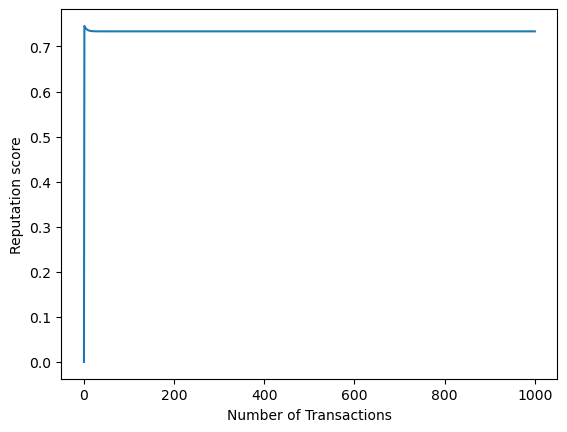

In [3]:
#declaring first time user parameters
user_age = 0
user_total_price_reviews = 0
total_reviews = 0
user_x = 1
user_rep = 0
price=2322070000000000.0 #5USD
# price = 443866700000000000.0 #1000USD
# price = 1000000000000000000.0 #2k USD
total_time_passed = 0.0
time_difference = 1.0

repList = []
xList = []
repList.append(0)
xList.append(0)

A_VALUE = 50 # remains the same
B_VALUE = 100
C_VALUE = 300
BETA1 = 0.99
BETA2 = 4000
count = 0

while user_rep < 99 and count<1000:
        total_time_passed += time_difference    
        user_x = calculateX_Buyer(user_x, time_difference, price, BETA1, BETA2)
        xList.append(user_x)
        user_rep = sigmoidal(user_x, A_VALUE, B_VALUE, C_VALUE)
        repList.append(user_rep)
        count += 1

        
print("Number of transactions needed: ", len(repList)-1)
print("Number of hours: ",(total_time_passed))
print("Number of days: ", (total_time_passed)/24)
print("Reputation Score: ", user_rep)


x = [i for i in range(len(repList))]
y = repList
plt.plot(x,y)
plt.xlabel("Number of Transactions")
plt.ylabel("Reputation score")

# Simulation 1: Can a user artificially inflate his reputation score within a short period of time? 


**Considerations**
1. If so, what is the tolerance?
2. How long before the reputation can be increased?

**Notes**
1. Here, the attacker spams review every hour. 
2. Different values of the hyperparameters are explored to choose the ones best to resist such attacks. 


**Hyperparameters**
1. B_VALUE
2. C_VALUE
3. BETA1
4. BETA2

In [4]:
df = pd.DataFrame(columns = ['B_VALUE', 'C_VALUE', 'BETA1', 'BETA2', 'transactions', 'ETH', 'hours', 'days', 'FinalScore'])

def sim1(b, c,b1, b2, TIME_DIFFERENCE):
    #Variables to keep track of
    total_time_passed = 0.0
    user_x = 1
    user_rep = 0
    repList = []
    xList = []
    price =2322070000000000
    count = 0
    time_difference = TIME_DIFFERENCE
    while user_rep < 99 and count<1000:
        total_time_passed += time_difference    
        user_x = calculateX_Buyer(user_x, time_difference, price, b1, b2)
        xList.append(user_x)
        user_rep = sigmoidal(user_x, 50, b, c)
        repList.append(user_rep)
        count += 1
        
    return len(repList), (len(repList))*2322070000000000/(10**18), total_time_passed, total_time_passed/24, user_rep

#the user tries to inflate within a month and price 100wei, time between transactions is one hour
for b in range(100, 1000, 100):
    for c in range(100, 1000, 100):
        for b1 in [0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]:
            for b2 in range(10, 100, 10): 
                transactions, ETH, hours, days, user_rep = sim1(b, c, b1, b2, 1.0)
                df.loc[len(df)] = [b, c, b1, b2, transactions, ETH, hours, days, user_rep]
    
df

,B_VALUE,C_VALUE,BETA1,BETA2,transactions,ETH,hours,days,FinalScore
0,100.0,100.0,0.90,10.0,1000.0,2.32207,1000.0,41.666667,0.248140
1,100.0,100.0,0.90,20.0,1000.0,2.32207,1000.0,41.666667,0.248140
2,100.0,100.0,0.90,30.0,1000.0,2.32207,1000.0,41.666667,0.248140
3,100.0,100.0,0.90,40.0,1000.0,2.32207,1000.0,41.666667,0.248140
4,100.0,100.0,0.90,50.0,1000.0,2.32207,1000.0,41.666667,0.248140
...,...,...,...,...,...,...,...,...,...
7285,900.0,900.0,0.99,50.0,1000.0,2.32207,1000.0,41.666667,0.027755
7286,900.0,900.0,0.99,60.0,1000.0,2.32207,1000.0,41.666667,0.027755
7287,900.0,900.0,0.99,70.0,1000.0,2.32207,1000.0,41.666667,0.027755
7288,900.0,900.0,0.99,80.0,1000.0,2.32207,1000.0,41.666667,0.027755


In [5]:
df.to_csv('Simulation_1_1Hour_New_Equation.csv')

# Simulation 2: Can a user artificially inflate his reputation score within a short period of time? 


**Considerations**
1. If so, what is the tolerance?
2. How long before the reputation can be increased?

**Notes**
1. Here, the attacker spams review every 24 hours. 
2. Different values of the hyperparameters are explored to choose the ones best to resist such attacks. 


**Hyperparameters**
1. B_VALUE
2. C_VALUE
3. BETA1
4. BETA2
5. BETA3
6. BETA4

In [6]:
df = pd.DataFrame(columns = ['B_VALUE', 'C_VALUE', 'BETA1', 'BETA2', 'transactions', 'ETH', 'hours', 'days', 'FinalScore'])

def sim2(b, c,b1, b2):
    #Variables to keep track of
    total_time_passed = 0.0
    user_x = 1
    user_rep = 0
    repList = []
    xList = []
    price =2322070000000000
    count = 0
    time_difference = 24.0
    while user_rep < 99 and count<1000:
        total_time_passed += time_difference 
        user_x = calculateX_Buyer(user_x, time_difference, price, b1, b2)
        xList.append(user_x)
        user_rep = sigmoidal(user_x, 50, b, c)
        repList.append(user_rep)
        count += 1
        
    return len(repList), (len(repList))*2322070000000000/(10**18), total_time_passed, total_time_passed/24, user_rep

#the user tries to inflate within a month and price 100wei, time between transactions is one hour
for b in range(100, 1000, 100):
    for c in range(100, 1000, 100):
        for b1 in [0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]:
            for b2 in range(500, 5000, 500): 
                transactions, ETH, hours, days, user_rep = sim2(b, c, b1, b2)
                df.loc[len(df)] = [b, c, b1, b2, transactions, ETH, hours, days, user_rep]
                
df

,B_VALUE,C_VALUE,BETA1,BETA2,transactions,ETH,hours,days,FinalScore
0,100.0,100.0,0.90,100.0,10.0,0.023221,240.0,10.0,99.486937
1,100.0,100.0,0.90,600.0,18.0,0.041797,432.0,18.0,99.751936
2,100.0,100.0,0.90,1100.0,24.0,0.055730,576.0,24.0,99.644826
3,100.0,100.0,0.90,1600.0,29.0,0.067340,696.0,29.0,99.162161
4,100.0,100.0,0.90,2100.0,35.0,0.081272,840.0,35.0,99.274139
...,...,...,...,...,...,...,...,...,...
8095,900.0,900.0,0.99,2600.0,35.0,0.081272,840.0,35.0,99.427622
8096,900.0,900.0,0.99,3100.0,38.0,0.088239,912.0,38.0,99.551776
8097,900.0,900.0,0.99,3600.0,41.0,0.095205,984.0,41.0,99.726739
8098,900.0,900.0,0.99,4100.0,43.0,0.099849,1032.0,43.0,99.361337


In [7]:
df.to_csv("Simulation_2_24Hour_New_Equation.csv")

# Simulation 3: Can a user artificially inflate his reputation score within a short period of time? 


**Considerations**
1. If so, what is the tolerance?
2. How long before the reputation can be increased?

**Notes**
1. Here, the attacker spams review at random time intervals
2. Different values of the hyperparameters are explored to choose the ones best to resist such attacks. 


**Hyperparameters**
1. B_VALUE
2. C_VALUE
3. BETA1
4. BETA2
5. BETA3
6. BETA4

In [8]:
df = pd.DataFrame(columns = ['B_VALUE', 'C_VALUE', 'BETA1', 'BETA2', 'transactions', 'ETH', 'hours', 'days', 'FinalScore'])
rand_list = []
for i in range(10000):
    rand_list.append(np.random.randint(0, 168))
rowV=0

#the user tries to inflate within a month and price 100wei, time between transactions is one hour
for b in range(100, 1000, 100):
    for c in range(100, 1000, 100):
        for b1 in [0.95, 0.96, 0.97, 0.98, 0.99]:
            for b2 in range(10, 100, 10): 
                transactions, ETH, hours, days, user_rep = sim1(b, c, b1, b2, rowV)
                df.loc[len(df)] = [b, c, b1, b2, transactions, ETH, hours, days, user_rep]
                rowV+=1
    
df

,B_VALUE,C_VALUE,BETA1,BETA2,transactions,ETH,hours,days,FinalScore
0,100.0,100.0,0.95,10.0,1000.0,2.322070,0.0,0.000000,0.248140
1,100.0,100.0,0.95,20.0,1000.0,2.322070,1000.0,41.666667,0.248140
2,100.0,100.0,0.95,30.0,1000.0,2.322070,2000.0,83.333333,0.248140
3,100.0,100.0,0.95,40.0,1000.0,2.322070,3000.0,125.000000,0.248140
4,100.0,100.0,0.95,50.0,1000.0,2.322070,4000.0,166.666667,0.248140
...,...,...,...,...,...,...,...,...,...
3640,900.0,900.0,0.99,50.0,12.0,0.027865,43680.0,1820.000000,99.959723
3641,900.0,900.0,0.99,60.0,12.0,0.027865,43692.0,1820.500000,99.959723
3642,900.0,900.0,0.99,70.0,12.0,0.027865,43704.0,1821.000000,99.959722
3643,900.0,900.0,0.99,80.0,12.0,0.027865,43716.0,1821.500000,99.959722


In [9]:
df.to_csv("Simulation_3_Arbitrary_Time_New_Equation.csv")

# Simulation 4: Can a user create multiple different accounts, to influence reviews? (spam attack with un trusted users)

**Considerations**
1. How tolerant is the system?
2. How many accounts is needed before you can significantly increase? Each account creates one transaction/review --> number of accounts == number of transactions


**Others**
1. Values `B_VALUE_S`, `C_VALUE_S`, `BETA_S1`, `BETA_S2` are chosen arbitrarily


In [10]:
# For the buyers we set 
A_VALUE = 50 # remains the same
B_VALUE = 5
C_VALUE = 95
BETA1 = 0.99
BETA2 = 5000

Total Transactions need to reach review score 99:  10000
Minimum Expenditure (ETH):  23.2207
Final Review score:  0.497512437810943


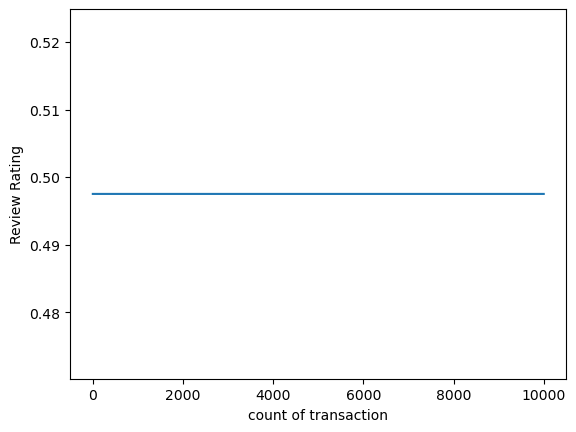

In [11]:
A_VALUE_S = 50 # remains the same
B_VALUE_S = 200 
C_VALUE_S = 800
BETA_S = 1
AVG_REVIEW = 1 #start 
OLD_X = 1 #start
R_INCOMING = 100
REP_SCORE = 0
review_list = []
count = 0

while count<10000 and AVG_REVIEW<99:
    count += 1
    X = calculateX_Seller(OLD_X, REP_SCORE, R_INCOMING, AVG_REVIEW, BETA_S)
    AVG_REVIEW = sigmoidal(X, A_VALUE_S, B_VALUE_S, C_VALUE_S)
    OLD_X = X
    review_list.append(AVG_REVIEW)
    
x = [i for i in range(len(review_list))]
y = review_list
plt.plot(x,y)
plt.xlabel("count of transaction")
plt.ylabel("Review Rating")
print("Total Transactions need to reach review score 99: ", len(review_list))
print("Minimum Expenditure (ETH): ", (len(review_list))*2322070000000000/(10**18))
print("Final Review score: ", AVG_REVIEW)

Total Transactions need to reach review score 99:  0
Minimum Expenditure (ETH):  0.0
Final Review score:  99


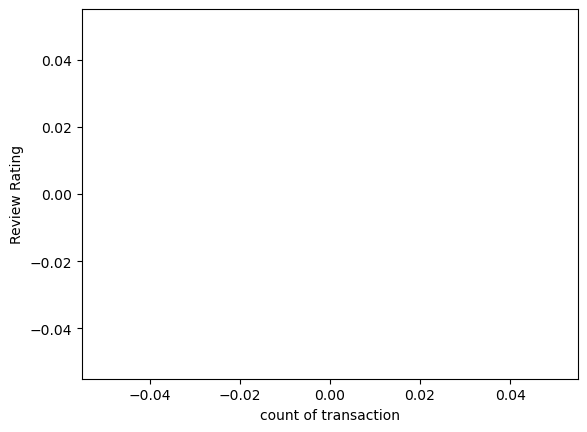

In [12]:
A_VALUE_S = 50 # remains the same
B_VALUE_S = 200 
C_VALUE_S = 800
BETA_S = 1
AVG_REVIEW = 99 #start 
OLD_X = 500 #start
R_INCOMING = 1
REP_SCORE = 0
review_list = []
count = 0

while count<10000 and AVG_REVIEW<99:
    count += 1
    X = calculateX_Seller(OLD_X, REP_SCORE, R_INCOMING, AVG_REVIEW, BETA_S)
    AVG_REVIEW = sigmoidal(X, A_VALUE_S, B_VALUE_S, C_VALUE_S)
    OLD_X = X
    review_list.append(AVG_REVIEW)
    
x = [i for i in range(len(review_list))]
y = review_list
plt.plot(x,y)
plt.xlabel("count of transaction")
plt.ylabel("Review Rating")
print("Total Transactions need to reach review score 99: ", len(review_list))
print("Minimum Expenditure (ETH): ", (len(review_list))*2322070000000000/(10**18))
print("Final Review score: ", AVG_REVIEW)

# Simulation 5: Can a user create multiple different accounts, to influence reviews? (spam attack with fully trusted users)

**Considerations**
1. How tolerant is the system?
2. How many transactions are needed before you can significantly increase?
3. What parameters can we set?

**Notes**
1. Hyperparameters are chosen arbitrarily, simply to see

Total Transactions need to reach review score 99:  5313
Minimum Expenditure (ETH):  12.33715791
Last review score:  [99.20121320316593]


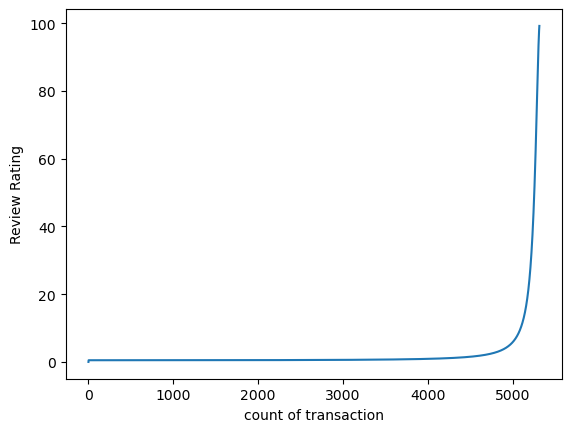

In [13]:
A_VALUE_S = 50 # remains the same
B_VALUE_S = 200 
C_VALUE_S = 800
BETA_S = 1
AVG_REVIEW = 0 #start 
OLD_X = 1 #start
R_INCOMING = 100
REP_SCORE = 99 #increase the score
review_list = []
count = 0
review_list.append(AVG_REVIEW)
while count<1000000000 and AVG_REVIEW<99:
    count += 1
    X = calculateX_Seller(OLD_X, REP_SCORE, R_INCOMING, AVG_REVIEW, BETA_S)
    AVG_REVIEW = sigmoidal(X, A_VALUE_S, B_VALUE_S, C_VALUE_S)
    OLD_X = X
    review_list.append(AVG_REVIEW)
    
x = [i for i in range(len(review_list))]
y = review_list
plt.plot(x,y)
plt.xlabel("count of transaction")
plt.ylabel("Review Rating")
print("Total Transactions need to reach review score 99: ", len(review_list))
print("Minimum Expenditure (ETH): ", (len(review_list))*2322070000000000/(10**18))
print("Last review score: ", review_list[-1:])

Total Transactions need to reach review score 1:  524683
Minimum Expenditure (ETH):  1218.35065381
Last review score:  [nan]


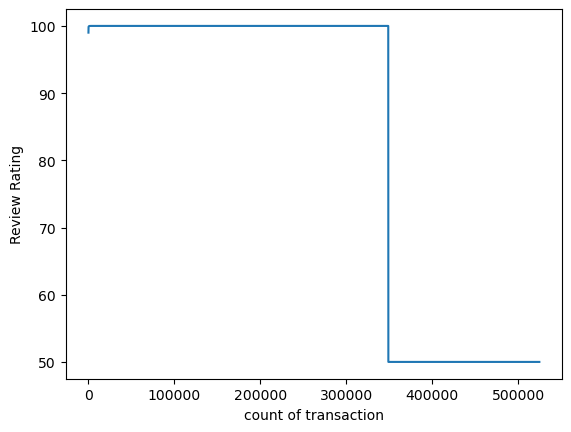

In [25]:
A_VALUE_S = 50 # remains the same
B_VALUE_S = 200 
C_VALUE_S = 800
BETA_S = 1
AVG_REVIEW = 99 #start 
OLD_X = 500 #start
R_INCOMING = 1 #reduce the score
REP_SCORE = 99
review_list = []
count = 0
review_list.append(AVG_REVIEW)
while count<1000000 and AVG_REVIEW>=1:
    count += 1
    X = calculateX_Seller(OLD_X, REP_SCORE, R_INCOMING, AVG_REVIEW, BETA_S)
    AVG_REVIEW = sigmoidal(X, A_VALUE_S, B_VALUE_S, C_VALUE_S)
    OLD_X = X
    review_list.append(AVG_REVIEW)
    
x = [i for i in range(len(review_list))]
y = review_list
plt.plot(x,y)
plt.xlabel("count of transaction")
plt.ylabel("Review Rating")
print("Total Transactions need to reach review score 1: ", len(review_list))
print("Minimum Expenditure (ETH): ", (len(review_list))*2322070000000000/(10**18))
print("Last review score: ", review_list[-1:])

# Simulation 6: Can a user create multiple different accounts, to influence reviews? (spam attack with fully trusted users)

**Considerations**
1. How tolerant is the system?
2. How many transactions are needed before you can significantly increase?
3. What parameters can we set?

**Notes**
1. Various values of hyperparameters are tested to see which will be most resistant

In [15]:
df = pd.DataFrame(columns = ['B_VALUE', 'C_VALUE', 'BETA_S','transactions','ETH', 'FinalReview'])

def sim6(A_VALUE_S, B_VALUE_S, C_VALUE_S, BETA_S):
    #Variables to keep track of
    AVG_REVIEW = 0 #start 
    OLD_X = 1 #start
    R_INCOMING = 100
    REP_SCORE = 99
    review_list = []
    count = 0
    review_list.append(AVG_REVIEW)

    while count<1000000000 and AVG_REVIEW<99:
        count += 1
        X = calculateX_Seller(OLD_X, REP_SCORE, R_INCOMING, AVG_REVIEW, BETA_S)
        AVG_REVIEW = sigmoidal(X, A_VALUE_S, B_VALUE_S, C_VALUE_S)
        OLD_X = X
        review_list.append(AVG_REVIEW)
    
    return len(review_list), AVG_REVIEW


#the user tries to inflate within a month and price 100wei, time between transactions is one hour
for b in range(100, 1000, 100):
    for c in range(100, 1000, 100):
        for beta_s in [0.01, 0.1, 1, 10, 20]:
                transactions, review = sim6(50, b, c, beta_s)
                df.loc[len(df)] = [b, c, beta_s, transactions, transactions*2322070000000000/(10**18), review]
    
df

,B_VALUE,C_VALUE,BETA_S,transactions,ETH,FinalReview
0,100.0,100.0,0.01,462794.0,1074.640064,99.004588
1,100.0,100.0,0.10,46285.0,107.477010,99.026174
2,100.0,100.0,1.00,4634.0,10.760472,99.185973
3,100.0,100.0,10.00,469.0,1.089051,99.922582
4,100.0,100.0,20.00,237.0,0.550331,99.828827
...,...,...,...,...,...,...
400,900.0,900.0,0.01,686639.0,1594.423823,99.005028
401,900.0,900.0,0.10,68670.0,159.456547,99.008159
402,900.0,900.0,1.00,6873.0,15.959587,99.095892
403,900.0,900.0,10.00,693.0,1.609195,99.696572


In [16]:
df.to_csv("Simulation_6a_Seller_New_Equation.csv")

In [ ]:
df = pd.DataFrame(columns = ['B_VALUE', 'C_VALUE', 'BETA_S','transactions','ETH', 'FinalReview'])

def sim6(A_VALUE_S, B_VALUE_S, C_VALUE_S, BETA_S):
    #Variables to keep track of
    AVG_REVIEW = 99 #start 
    OLD_X = 10000 #start
    R_INCOMING = 1
    REP_SCORE = 99
    review_list = []
    count = 0
    review_list.append(AVG_REVIEW)

    while count<1000000000 and AVG_REVIEW<99:
        count += 1
        X = calculateX_Seller(OLD_X, REP_SCORE, R_INCOMING, AVG_REVIEW, BETA_S)
        AVG_REVIEW = sigmoidal(X, A_VALUE_S, B_VALUE_S, C_VALUE_S)
        OLD_X = X
        review_list.append(AVG_REVIEW)
    
    return len(review_list), AVG_REVIEW


#the user tries to inflate within a month and price 100wei, time between transactions is one hour
for b in range(100, 1000, 100):
    for c in range(100, 1000, 100):
        for beta_s in [0.01, 0.1, 1, 10, 20]:
                transactions, review = sim6(50, b, c, beta_s)
                df.loc[len(df)] = [b, c, beta_s, transactions, transactions*2322070000000000/(10**18), review]
    
df

In [ ]:
df.to_csv("Simulation_6a_Seller_New_Equation.csv")

# Simulation 7: Can we use the same account, starting with no reputation, to gain reputation and leave a review?

**Considerations**
1. How tolerant is the system?
2. How many transactions is needed?

We know that we cannot deviate too far from the rating to affect the product rating. We also know we cannot have too much time in between the transaction. Additionally, we need to reduce the cost as much as possible for the attack. 

Let us say for each review left by the user, they receive a reward. Let us say they receive 10% of the product price multiplied by their reputation score. 

In [17]:
A_VALUE = 50 # remains the same
B_VALUE = 100 
C_VALUE = 300

A_VALUE_S = 50 # remains the same
B_VALUE_S = 300 
C_VALUE_S = 900

BETA_S = 1
BETA_1 = 0.99
BETA_2 = 4000

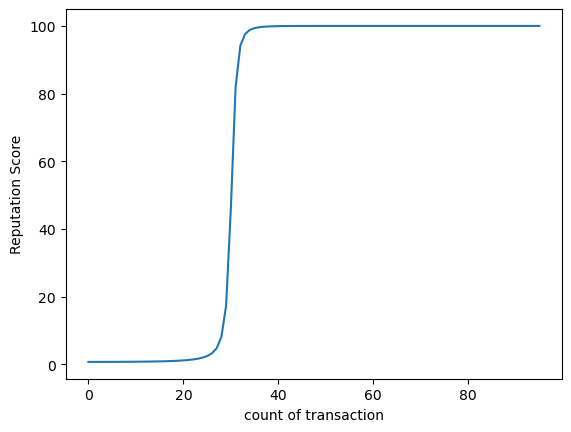

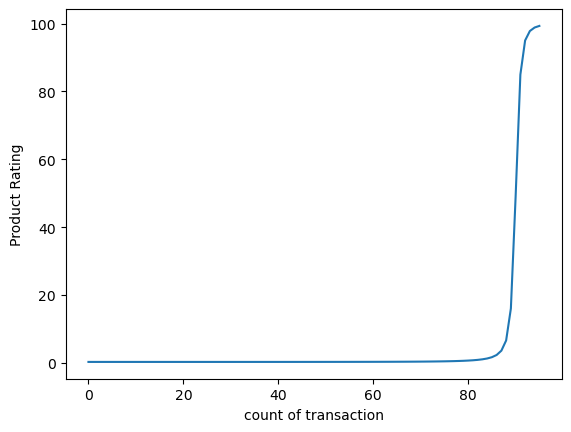

Final Reputation Score:  99.99999999664583
Final Rating:  99.33581279060719
Total Transactions needed:  96
Total number of days:  96.0
Total Cost of Purchasing Product:  0.22291872
Total Reward Obtained:  0.015272892247477955
Net Gain/Loss:  0.20764582775252202
Net Gain in USD:  445.82216710775253


In [18]:
AVG_REVIEW = 0
X_SELLER = 1
REP_SCORE = 0
X_BUYER = 1
R_INCOMING = 0
PRICE = 2322070000000000
AVG_REVIEW_LIST = []
REP_SCORE_LIST = []
TOTAL_REWARD = 0
TIMEDIFF = 24

count = 0
while AVG_REVIEW<99 and count<10000:
#     print("Seller X: ", X_SELLER)
#     print("Seller Review: ", AVG_REVIEW)
#     print("Buyer X: ", X_BUYER)
#     print("Buyer Reputation: ", REP_SCORE)
#     print("..................")
    
    # give the seller the review 
    X_SELLER = calculateX_Seller(X_SELLER, REP_SCORE, R_INCOMING, AVG_REVIEW, BETA_S)
    AVG_REVIEW = sigmoidal(X_SELLER, A_VALUE_S, B_VALUE_S, C_VALUE_S)
    AVG_REVIEW_LIST.append(AVG_REVIEW)
    
        
    X_BUYER = calculateX_Buyer(X_BUYER, TIMEDIFF, PRICE, BETA1, BETA2)
    REP_SCORE = sigmoidal(X_BUYER, A_VALUE, B_VALUE, C_VALUE)
    REP_SCORE_LIST.append(REP_SCORE)
    TOTAL_REWARD += 0.10 * PRICE * REP_SCORE/100
    
    R_INCOMING = AVG_REVIEW + 1 
    count += 1
    
    

x = [i for i in range(len(REP_SCORE_LIST))]
y = REP_SCORE_LIST
plt.plot(x,y)
plt.xlabel("count of transaction")
plt.ylabel("Reputation Score")    
plt.show()
    
x = [i for i in range(len(AVG_REVIEW_LIST))]
y = AVG_REVIEW_LIST
plt.plot(x,y)
plt.xlabel("count of transaction")
plt.ylabel("Product Rating")    
plt.show()

print("Final Reputation Score: ", REP_SCORE)
print("Final Rating: ", AVG_REVIEW)
print("Total Transactions needed: ", count)
print("Total number of days: ", count*TIMEDIFF/24)
print("Total Cost of Purchasing Product: ", PRICE*count/(10**18))
print("Total Reward Obtained: ", TOTAL_REWARD/(10**18))
print("Net Gain/Loss: ", PRICE*count/(10**18)-TOTAL_REWARD/(10**18))
print("Net Gain in USD: ", 2000*PRICE*count/(10**18)-TOTAL_REWARD/(10**18))